In [1]:
import os

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from tqdm import tqdm, tqdm_notebook, notebook

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

# Проект для «Викишоп» с BERT (но он не тут, а в colabe)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Очистка-текстов" data-toc-modified-id="Очистка-текстов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Очистка текстов</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков-методом-TF-IDF" data-toc-modified-id="Подготовка-признаков-методом-TF-IDF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка признаков методом TF-IDF</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров-Логистической-Регрессии" data-toc-modified-id="Подбор-гиперпараметров-Логистической-Регрессии-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Подбор гиперпараметров Логистической Регрессии</a></span></li><li><span><a href="#Логистическая-регрессия-на-признаках-через-CountVectorizer" data-toc-modified-id="Логистическая-регрессия-на-признаках-через-CountVectorizer-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Логистическая регрессия на признаках через CountVectorizer</a></span></li></ul></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LinearSVC</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Наша задача - построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Для начала загрузим наши данные.

In [2]:
tweets_df = pd.read_csv('toxic_comments.csv')

Посмотрим какое количество коментариев от общего числа помечены как токсичные. Проверим токсичность интернета!

In [3]:
print(f"В твиттере {tweets_df.toxic.mean():.2%} токсичных комментариев")

В твиттере 10.17% токсичных комментариев


Ну не так уж и много) Посмотрим, что там народ пишет:

In [4]:
tweets_df.sample(5, random_state=SEED)

,text,toxic
119105,"Geez, are you forgetful! We've already discus...",0
131631,Carioca RFA \n\nThanks for your support on my ...,0
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0
111256,Pseudoscience category? \n\nI'm assuming that ...,0
83590,"(and if such phrase exists, it would be provid...",0


Имеем тексты на английском, в которых куча лишних знаков.

Надо подготовить наши данные для обучения. 
- Очистим тексты от всего, что не слова и приведем все к нижнему регистру
- Лемматизируем тексты 

### Очистка текстов

Подготовим функцию, которая приведет все слова в текстах к нижнему регистру и уберет все лишние знаки с помощью регулярных выражений. Так же попробуем учесть некоторые сокращения, чтобы как можно меньше терять смысл например на отрицаниях.

In [5]:
def cleaner(row):
    text = row['text'].lower()
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"shan't", "shall not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()

    return text

In [6]:
tweets_df['cleaned_text'] = tweets_df.apply(cleaner, axis=1)

In [7]:
tweets_df.sample(10, random_state=SEED)

,text,toxic,cleaned_text
119105,"Geez, are you forgetful! We've already discus...",0,geez are you forgetful we have already discus...
131631,Carioca RFA \n\nThanks for your support on my ...,0,carioca rfa thanks for your support on my re...
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,birthday no worries it is what i do enjoy ur...
111256,Pseudoscience category? \n\nI'm assuming that ...,0,pseudoscience category i am assuming that th...
83590,"(and if such phrase exists, it would be provid...",0,and if such phrase exists it would be provided...
37546,", 9 October 2007 (UTC)\n\nP.s, the delta funct...",0,october utc ps the delta function i use in t...
98371,"]]- 10 September 1910, [[[Couvet]] )",0,september couvet
67118,Negro league baseball task-force talk].,0,negro league baseball taskforce talk
129625,List of My Three Sons episodes \n\nI saw you r...,0,list of my three sons episodes i saw you red...
48941,Quoting Loremaster: In order to make sure you ...,0,quoting loremaster in order to make sure you u...


### Лемматизация

Следующие две функции работают в связке. Функция `lemmatization` принимает на вход столбец, потом каждая запись в строке разбивается на отдельные слова и для каждого слова вызывается функция `pos_tag_wordnet`, которая возвращает само слово и тэг части речи, к которой это слово пренадлежит. Эти данные подаются на вход `wordnet_lemmatizer`'у, который в свою очередь возвращает лемму этого слова. Все леммы собираются обратно во фразу и фразы в Series. Функция возвращает этот Series.

In [8]:
def pos_tag_wordnet(text):
    """
        Create pos_tag with wordnet format
    """
    wordnet_map = {
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "J": wordnet.ADJ,
        "R": wordnet.ADV
    }

    pos_tagged_text = nltk.pos_tag(text)

    pos_tagged_text = [
        (word,
         wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else
        (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text
    ]

    return pos_tagged_text


def lemmatization(clmn: pd.Series):

    wordnet_lemmatizer = WordNetLemmatizer()

    new_result = []

    for phrase in clmn:
        pos_tag = pos_tag_wordnet([i for i in phrase.split()])
        new_phrase = str()
        for word in pos_tag:
            new_phrase += " " + (wordnet_lemmatizer.lemmatize(word[0],
                                                              pos=word[1]))
        new_result.append(new_phrase)

    return pd.Series(new_result)

In [9]:
%%time
tweets_df['lemmas'] = lemmatization(tweets_df['cleaned_text'])

Wall time: 9min 55s


In [10]:
tweets_df.sample(10, random_state=SEED)

,text,toxic,cleaned_text,lemmas
119105,"Geez, are you forgetful! We've already discus...",0,geez are you forgetful we have already discus...,geez be you forgetful we have already discuss...
131631,Carioca RFA \n\nThanks for your support on my ...,0,carioca rfa thanks for your support on my re...,carioca rfa thanks for your support on my req...
125326,"""\n\n Birthday \n\nNo worries, It's what I do ...",0,birthday no worries it is what i do enjoy ur...,birthday no worry it be what i do enjoy ur da...
111256,Pseudoscience category? \n\nI'm assuming that ...,0,pseudoscience category i am assuming that th...,pseudoscience category i be assume that this ...
83590,"(and if such phrase exists, it would be provid...",0,and if such phrase exists it would be provided...,and if such phrase exist it would be provide ...
37546,", 9 October 2007 (UTC)\n\nP.s, the delta funct...",0,october utc ps the delta function i use in t...,october utc ps the delta function i use in th...
98371,"]]- 10 September 1910, [[[Couvet]] )",0,september couvet,september couvet
67118,Negro league baseball task-force talk].,0,negro league baseball taskforce talk,negro league baseball taskforce talk
129625,List of My Three Sons episodes \n\nI saw you r...,0,list of my three sons episodes i saw you red...,list of my three son episodes i saw you redir...
48941,Quoting Loremaster: In order to make sure you ...,0,quoting loremaster in order to make sure you u...,quote loremaster in order to make sure you un...


In [11]:
lemm_tweets_df = tweets_df.drop(columns=['text', 'cleaned_text'])
del (tweets_df)

In [12]:
lemm_tweets_df

,toxic,lemmas
0,0,explanation why the edits make under my usern...
1,0,daww he match this background colour i be see...
2,0,hey man i be really not try to edit war it be...
3,0,more i can not make any real suggestion on im...
4,0,you sir be my hero any chance you remember wh...
...,...,...
159566,0,and for the second time of ask when your view...
159567,0,you should be ashamed of yourself that be a h...
159568,0,spitzer umm theres no actual article for pros...
159569,0,and it look like it be actually you who put o...


В результате проделанных манипуляций мы получили наш датасет с очищенными и лемматизироваными текстами. Можно приступать к подготовке признаков и обучению моделей.

## Обучение

### Подготовка признаков методом TF-IDF

Разделим наш датасет на обучающую и тестовую выборки. В исходном датасете всего 10,5% токсичных комментариев. В смысле это хорошо, но будет плохо если они все попадут в одну часть нашей выборки. Поэтому разделение будет со стратификацией.

In [13]:
train, test = train_test_split(lemm_tweets_df,
                               test_size=0.25,
                               random_state=SEED,
                               stratify=lemm_tweets_df['toxic'])

Теперь подготовим инструменты, которые очистят наши тексты от ненужных стоп-слов и потом преобразуют их по методу TF-IDF. 

TF-IDF — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции

In [43]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kvasilkov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Теперь получим матрицы TF-IDF для наших наборов. Для трейна используем метод fit_transform, а вот для теста только transform, чтобы данные не утекли раньше времени.

In [44]:
tf_idf_train = count_tf_idf.fit_transform(train['lemmas'])
tf_idf_test = count_tf_idf.transform(test['lemmas'])

In [45]:
print("Размер матрицы признаков обучающей выборки:", tf_idf_train.shape)
print("Размер матрицы признаков тестовой выборки:", tf_idf_test.shape)

Размер матрицы признаков обучающей выборки: (119678, 172255)
Размер матрицы признаков тестовой выборки: (39893, 172255)


### Логистическая регрессия

Обучим на этих признаках логистическую регрессию.

In [46]:
model_log_reg = LogisticRegression(random_state=SEED, max_iter=110)

model_log_reg.fit(tf_idf_train, train.toxic)

LogisticRegression(max_iter=110, random_state=42)

In [47]:
f1_score(test['toxic'], model_log_reg.predict(tf_idf_test))

0.7328584149599288

В лоб построить модель, которая будет делать предсказания с достаточной точностью не получилось. Попробуем затюнить нашу логистическую регрессию через подбор гиперпарамметров.

#### Подбор гиперпараметров Логистической Регрессии

In [48]:
log_reg_tf_idf = LogisticRegression(random_state=SEED,
                                    solver='liblinear',
                                    max_iter=500,
                                    verbose=True)

params = [{
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200]
}]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

grid_log_reg_tf_idf = GridSearchCV(log_reg_tf_idf,
                                   param_grid=params,
                                   scoring='f1',
                                   cv=cv,
                                   verbose=True,
                                   n_jobs=-1)

In [49]:
%%time
grid_log_reg_tf_idf.fit(tf_idf_train, train.toxic)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  9.1min finished


[LibLinear]Wall time: 9min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=500, random_state=42,
                                          solver='liblinear', verbose=True),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'liblinear']}],
             scoring='f1', verbose=True)

In [50]:
best_log_reg_tf_idf = grid_log_reg_tf_idf.best_estimator_

In [51]:
best_log_reg_tf_idf

LogisticRegression(C=10, max_iter=500, penalty='l1', random_state=42,
                   solver='liblinear', verbose=True)

In [52]:
f1_score(test['toxic'], best_log_reg_tf_idf.predict(tf_idf_test))

0.7731796752226296

Как видно из результатов, нам удалось неплохо увеличить метрику F1 на подборе гиперпарамметров нашей логгистической регрессии и признаках, сформированных по методу TF-IDF.

Давайте теперь попробуем подобрать порог для нашей модели.

In [53]:
def best_treshhold_choice(model, features, target, model_name):
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]

    # Stage1 - choising best treshhold in range 0-1 with step 0.1
    stage1_best_trhld = 0
    stage1_best_f1 = 0
    for threshold in np.arange(0, 1, 0.1):
        predicted = probabilities_one > threshold
        f_score = f1_score(target, predicted)
        if f_score > stage1_best_f1:
            stage1_best_trhld = threshold
            stage1_best_f1 = f_score

    # Stage2 - choising best treshhold in range stage1_best_trhld +- 0.1 with step 0.005
    best_recall = 0
    best_precision = 0
    best_threshold = 0
    best_f1_score = 0
    for threshold in np.arange(stage1_best_trhld - 0.1,
                               stage1_best_trhld + 0.1, 0.005):
        predicted = probabilities_one > threshold
        precision = precision_score(target, predicted)
        recall = recall_score(target, predicted)
        f_score = f1_score(target, predicted)
        if f_score > best_f1_score:
            best_recall = recall
            best_precision = precision
            best_threshold = threshold
            best_f1_score = f_score

    print(f'Для модели "{model_name}"')
    print(
        "Лучший порог = {:.4f}  Точность = {:.3f}, Полнота = {:.3f}, F1-мера = {:.3f}"
        .format(best_threshold, best_precision, best_recall, best_f1_score))
    return model_name, best_threshold, best_precision, best_recall, best_f1_score

In [54]:
result_table = []

In [55]:
result_table.append(
    best_treshhold_choice(best_log_reg_tf_idf, tf_idf_test, test['toxic'],
                          "Best_LogReg_TF-IDF"))

Для модели "Best_LogReg_TF-IDF"
Лучший порог = 0.4150  Точность = 0.805, Полнота = 0.747, F1-мера = 0.775


In [56]:
result_table

[('Best_LogReg_TF-IDF',
  0.41500000000000015,
  0.8054743555673665,
  0.7472879684418146,
  0.7752909579230081)]

#### Логистическая регрессия на признаках через CountVectorizer

Следующим шагом проверим не улучшится ли качество модели логистическо регрессии если вместо TF-IDF мы будем использовать встроенную в sklearn.feature_extraction.text CountVectorizer. 

In [57]:
pipe = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1, 1))),
                 ('model',
                  LogisticRegression(random_state=SEED,
                                     solver='liblinear',
                                     max_iter=500))])

params = [{
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'model': [LogisticRegression(random_state=SEED, solver='liblinear')],
    'model__C': [1, 10, 50, 100, 200]
}]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

grid_log_reg_cntvec = GridSearchCV(pipe,
                                   param_grid=params,
                                   scoring='f1',
                                   cv=cv,
                                   verbose=True,
                                   n_jobs=-1)

In [58]:
%%time
grid_log_reg_cntvec.fit(train.lemmas, train.toxic)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 20.8min finished


Wall time: 22min 34s


C:\Users\kvasilkov\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('model',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression(C=10, random_state=42,
                                                       solver='liblinear')],
                          'model__C': [1, 10, 50, 100, 200],
                          'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)]}],
             scoring='f1', verbose=True)

In [59]:
grid_log_reg_cntvec.best_params_, grid_log_reg_cntvec.best_score_

({'model': LogisticRegression(C=10, random_state=42, solver='liblinear'),
  'model__C': 10,
  'vectorizer__ngram_range': (1, 2)},
 0.7401999311500435)

In [60]:
%%time
best_grid_log_reg_cntvec = grid_log_reg_cntvec.best_estimator_

best_grid_log_reg_cntvec.fit(train.lemmas, train.toxic)

Wall time: 1min 35s


C:\Users\kvasilkov\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(C=10, random_state=42,
                                    solver='liblinear'))])

In [61]:
result_table.append(
    best_treshhold_choice(best_grid_log_reg_cntvec, test.lemmas, test.toxic,
                          "Best_LogReg_CntVec"))

Для модели "Best_LogReg_CntVec"
Лучший порог = 0.2200  Точность = 0.752, Полнота = 0.789, F1-мера = 0.770


Только после сильного снижения порога, эта модель показывает результат примерно на уровне предыдущей. Запишем ее результаты и пойдем дальше.

### LinearSVC

Следующей попробуем обучить модель LinearSVC. Ее будем обучать на признаках полученных методом TF-IDF.

In [62]:
%%time

svc_pipe = make_pipeline(LinearSVC(
    random_state=SEED,
    max_iter=20000,
),
                         verbose=True)
svc_pipe.fit(tf_idf_train, train.toxic)

[Pipeline] ......... (step 1 of 1) Processing linearsvc, total=   1.0s
Wall time: 1.04 s


Pipeline(steps=[('linearsvc', LinearSVC(max_iter=20000, random_state=42))],
         verbose=True)

In [63]:
svc = LinearSVC(random_state=SEED, max_iter=20000, verbose=True)

params = [{
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200]
}]

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

grid_svc_tf_idf = GridSearchCV(svc,
                               param_grid=params,
                               scoring='f1',
                               cv=cv,
                               verbose=True,
                               n_jobs=-1)

In [64]:
%%time
grid_svc_tf_idf.fit(tf_idf_train, train.toxic)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


[LibLinear]Wall time: 1min 52s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LinearSVC(max_iter=20000, random_state=42, verbose=True),
             n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200],
                          'penalty': ['l1', 'l2']}],
             scoring='f1', verbose=True)

In [65]:
best_grid_svc_tf_idf = grid_svc_tf_idf.best_estimator_

In [66]:
result_table.append(("Best_SVC_TF-IDF", 'N/A',
                     precision_score(test['toxic'],
                                     best_log_reg_tf_idf.predict(tf_idf_test)),
                     recall_score(test['toxic'],
                                  best_log_reg_tf_idf.predict(tf_idf_test)),
                     f1_score(test['toxic'],
                              best_log_reg_tf_idf.predict(tf_idf_test))))

In [67]:
final_table = pd.DataFrame(
    data=result_table,
    columns=['Model', 'threshold', 'Precision', 'Recall', 'F1'],
)
final_table.set_index('Model', drop=True, inplace=True)

In [68]:
final_table

,threshold,Precision,Recall,F1
Model,,,,
Best_LogReg_TF-IDF,0.415,0.805474,0.747288,0.775291
Best_LogReg_CntVec,0.22,0.751820,0.789448,0.770174
Best_SVC_TF-IDF,N/A,0.824581,0.727811,0.773180


In [69]:
def show_roc_curve(clsfr, features, target):
    probabilities_valid = clsfr.predict_proba(features)
    probabilities_one_valid = probabilities_valid[:, 1]

    fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)

    auc_roc = roc_auc_score(target, probabilities_one_valid)

    plt.figure(figsize=(10, 10))
    lw = 2
    plt.plot(fpr,
             tpr,
             color='darkorange',
             lw=lw,
             label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

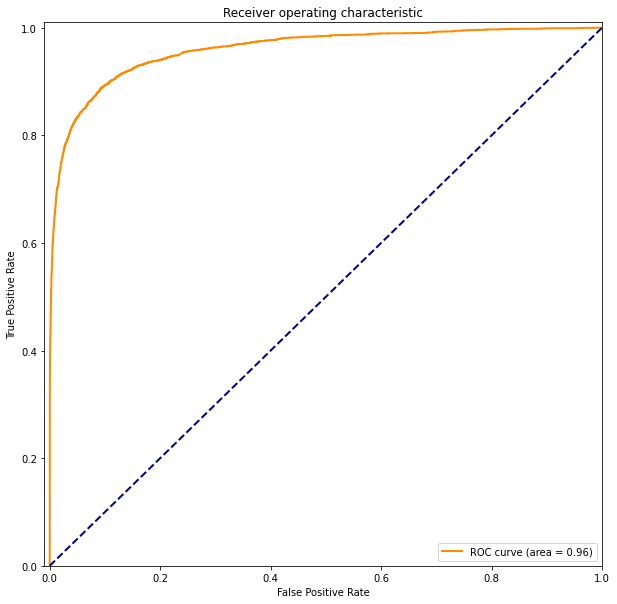

In [70]:
show_roc_curve(best_log_reg_tf_idf, tf_idf_test, test['toxic'])

## BERT

[Вот тут лежит моя тетрадка с BERT](https://colab.research.google.com/drive/18eQ1ELXt8sLB2CWvtz494gjQzkvMQOjt?usp=sharing)

Внутри есть дополнительный дисклеймер, но в общих чертах BERT показал себя лучше чем простые модели и с ним получилось улучшить метрику до ~0.83.

## Выводы

По результатам работы можно сказать, что даже с использованием простых, но подогнанных под задачу моделей, вполне можно достичь приличного результата. Нейронная сеть показывает результаты лучше, но даже просто, чтобы донастроить ее, требуются значительне ресурсы как со стороны железа, так и время.